In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from lbg_forecast import emulator as em
from lbg_forecast import population_model as pop

In [2]:
bands = ["u"]#,"g","r","i","z","y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

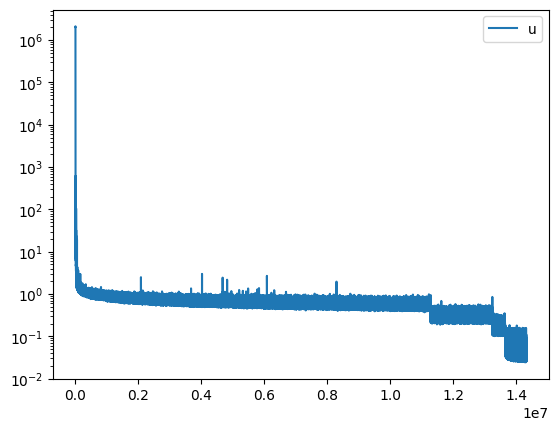

In [3]:
i = 0
for x in loss_bands:
    plt.plot(x, label=bands[i])
    i+=1

plt.yscale("log")
plt.legend()

0.03081495128571987


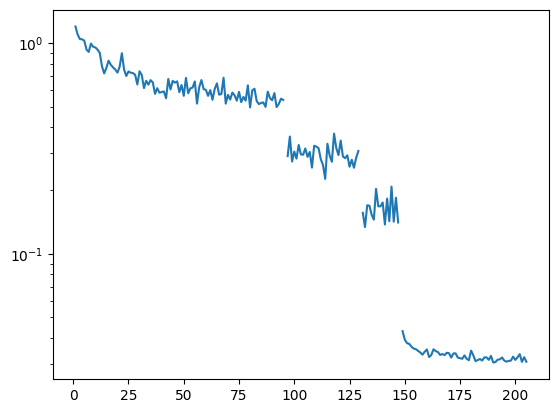

In [4]:
i = 0
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [42]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


(3.631e-36, 3.6310000000000006e-24)

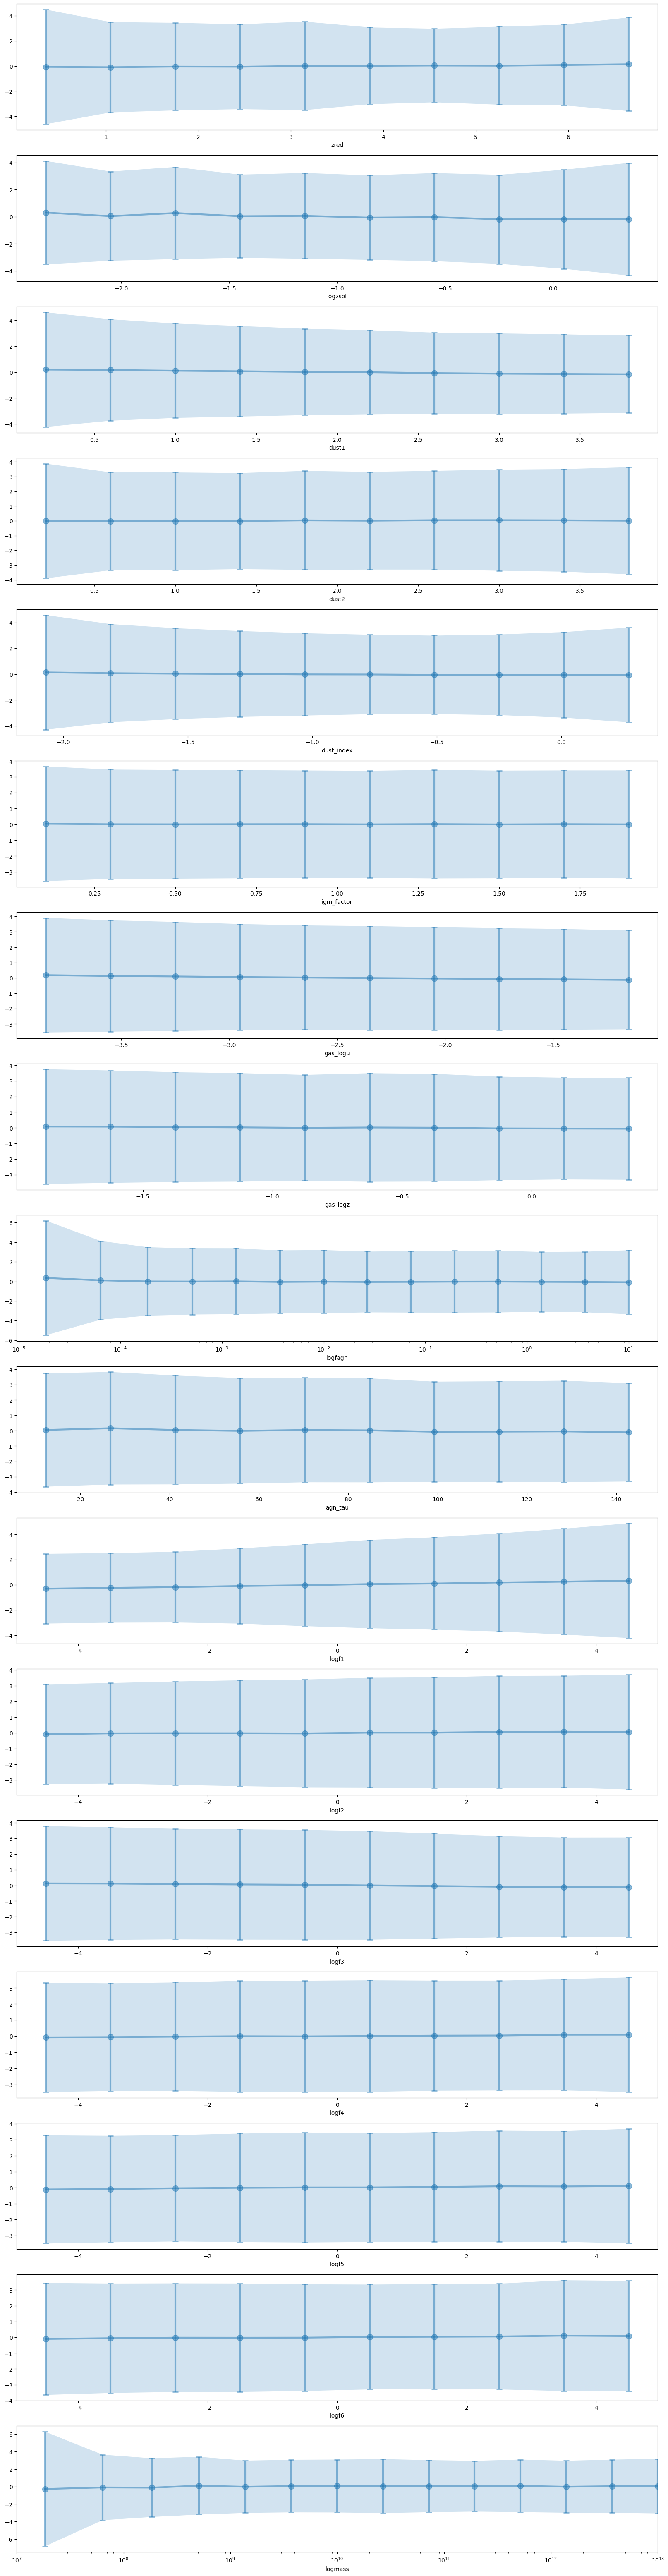

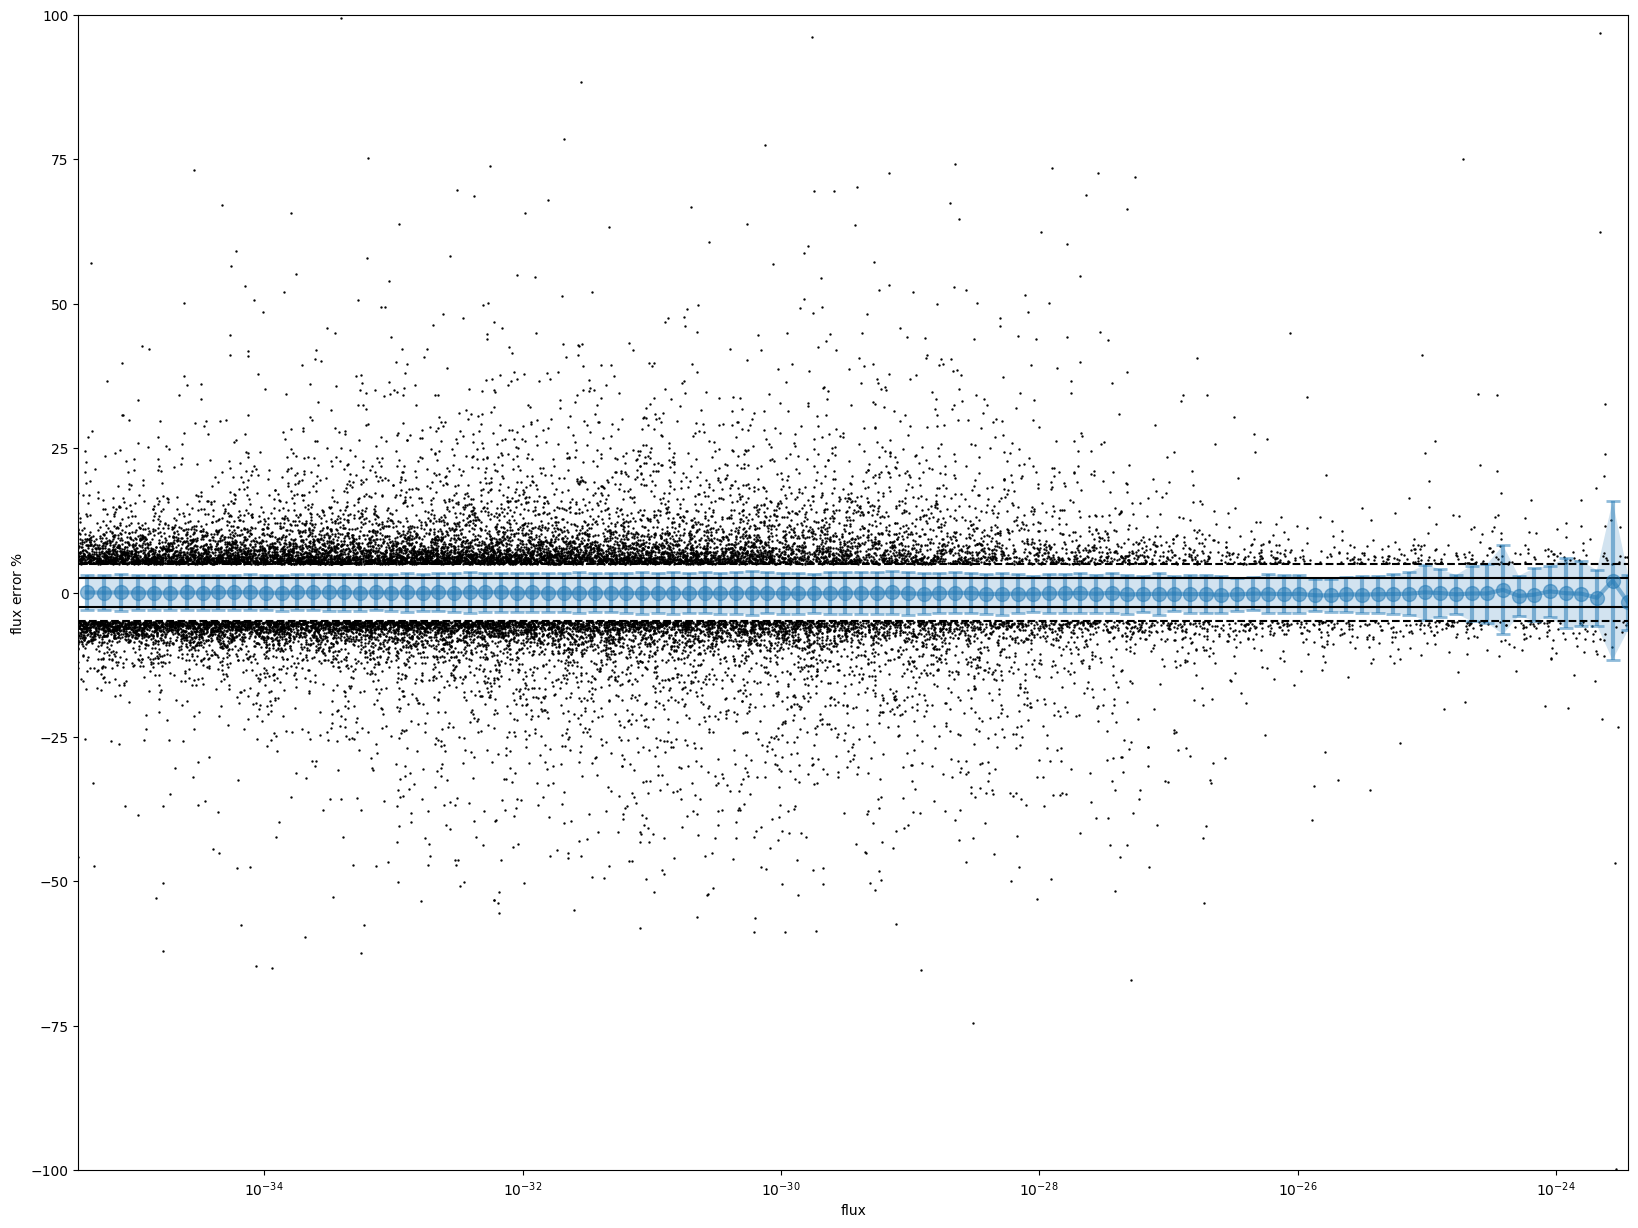

In [43]:
def mab_to_flux(mag):
    return 3.631e-20*10**(-(mag/2.5))

def quantile(data):
    return np.quantile(data, 0.95)

def get_outliers(flux_err, threshold):
    inds = np.where(abs(flux_err) > threshold)[0]
    return inds

min_flux = mab_to_flux(40)
max_flux = mab_to_flux(10)


nsamples=1000000
band = 0
y_bound = 5.0
batch_size = 10000

sps_params = sps_params_train[:nsamples, :]
flux_mimic = mab_to_flux(model.mimic_photometry(sps_params[:,], batch_size=batch_size))
flux_true = mab_to_flux(phot_train[:nsamples, :])
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        flux_err = ((flux_mimic[:, j]-flux_true[:, j])/(flux_true[:, j]))*100
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], flux_err[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], flux_err[:,],quantile, bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], flux_err[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], flux_err[:,],quantile)
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)




fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(flux_true[:, j], flux_err[:,],'mean', np.logspace(np.log10(min_flux), np.log10(max_flux), 100))
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(flux_true[:, j], flux_err[:,],quantile, np.logspace(np.log10(min_flux), np.log10(max_flux), 100))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = get_outliers(flux_err, y_bound)

    axes2.scatter(flux_true[inds, np.ones_like(inds)*j], flux_err[inds], s=0.5, c='k')



axes2.set_xlabel('flux')
axes2.set_ylabel('flux error $\%$')
axes2.set_xscale('log')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

axes2.axhline(y=y_bound/2, color='k', linestyle='-')
axes2.axhline(y=-y_bound/2, color='k', linestyle='-')

#axes2.axhline(y=1, color='k', linestyle='-')
#axes2.axhline(y=-1, color='k', linestyle='-')

#axes2.axvline(x=10, color='k', linestyle='--')
#axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-100, 100)

axes2.set_xlim(min_flux, max_flux)


In [24]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


total outliers:  5.1722


(-1.5, 1.5)

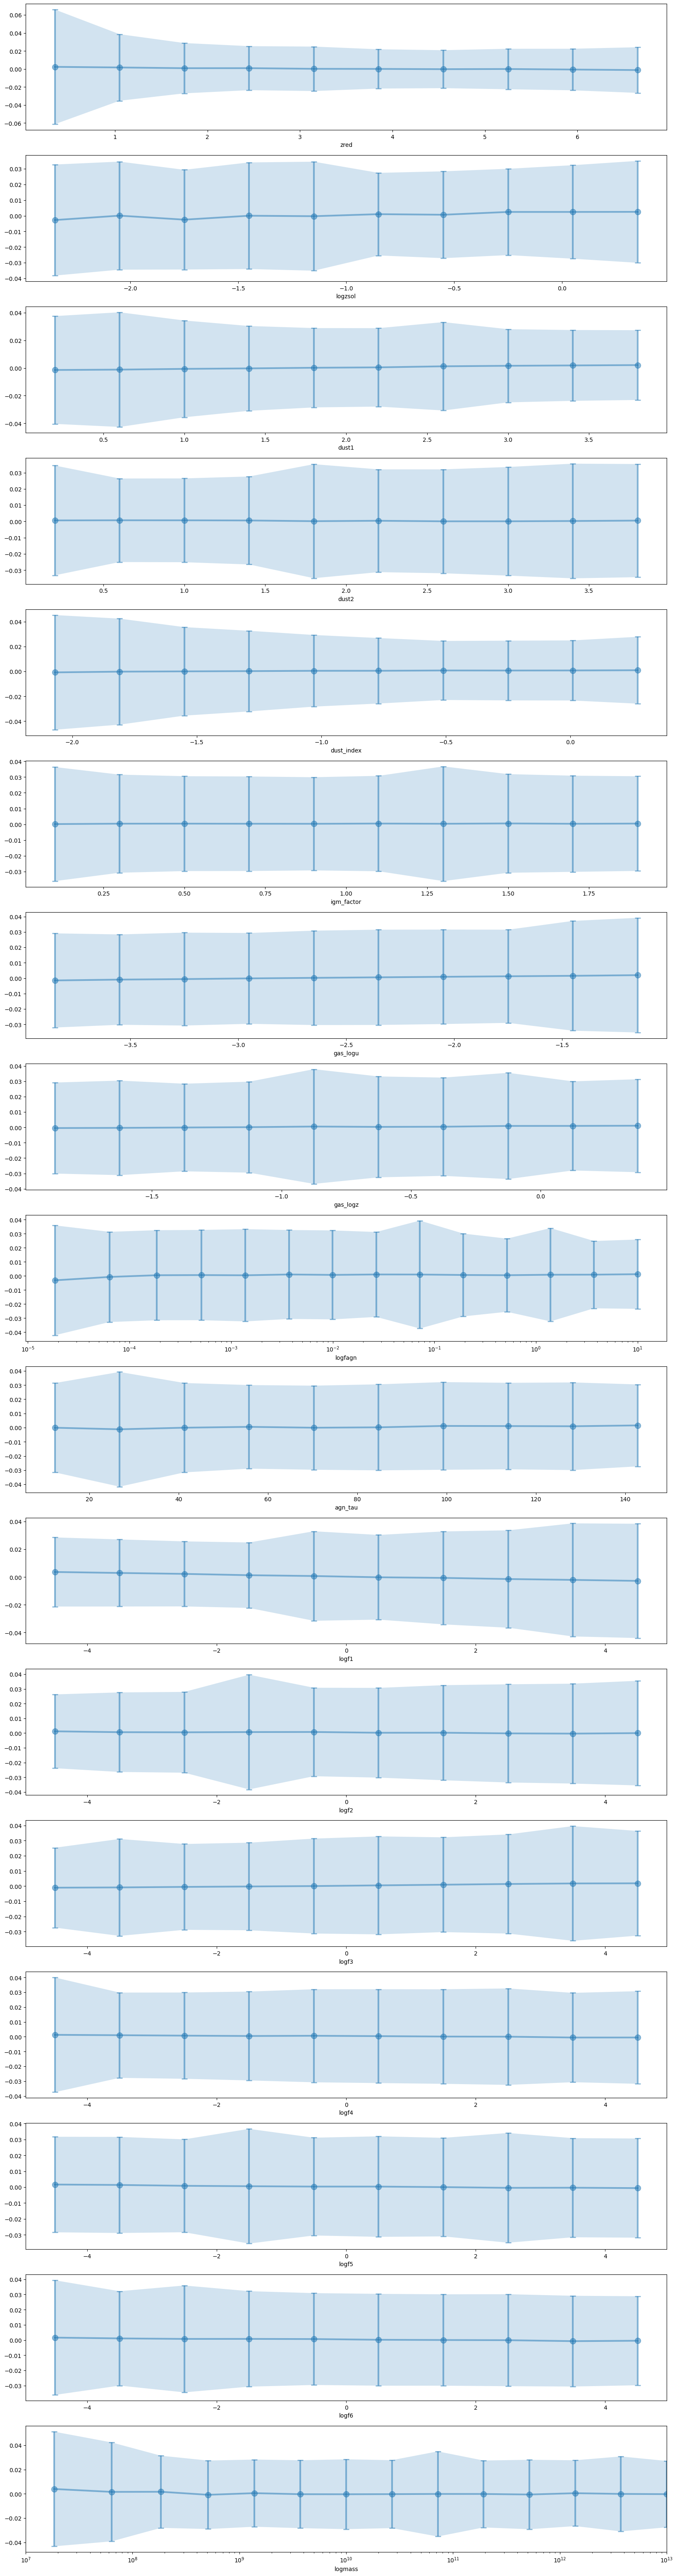

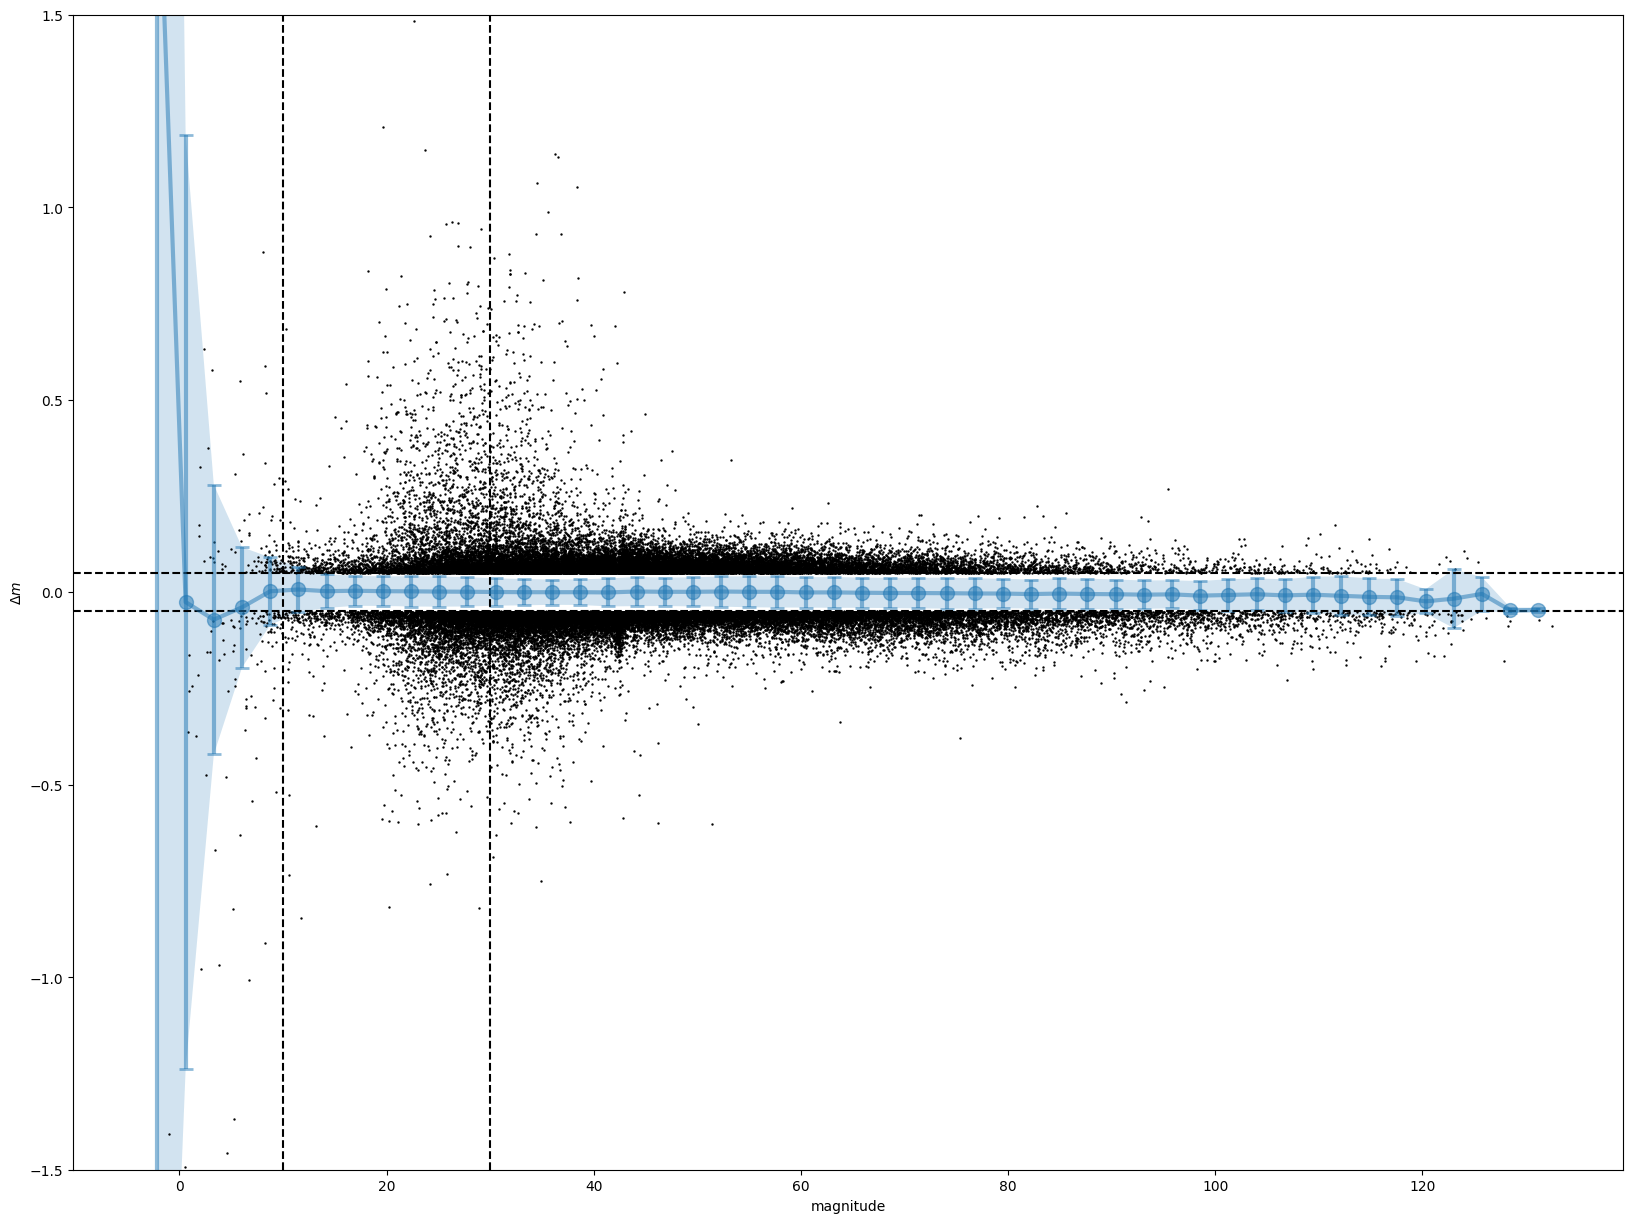

In [25]:
nsamples=1000000
y_bound = 0.05
sps_params = sps_params_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params[:,], batch_size=10000)
m_true = phot_train[:nsamples, :]
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = m_mimic[:, j]-m_true[:, j]
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', 50)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],quantile, 50)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

#axes2.axhline(y=0.1, color='k', linestyle='-')
#axes2.axhline(y=0.1, color='k', linestyle='-')

axes2.axvline(x=10, color='k', linestyle='--')
axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-1.5, 1.5)

#axes2.set_xlim(0, 40)


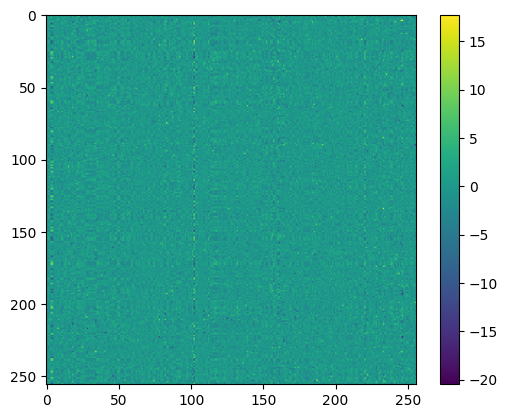

In [10]:
weights = model._models[0].W
biases = model._models[0].b
a = model._models[0].alphas
b = model._models[0].betas

layer = 5

weights[layer].shape

plt.imshow(np.transpose(weights[layer]))
plt.colorbar()

(array([ 3.,  3.,  1., 24., 56., 61., 58., 26.,  8.,  3.,  5.,  1.,  2.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.12558192, -0.10141759, -0.07725326, -0.05308893, -0.0289246 ,
        -0.00476027,  0.01940406,  0.04356839,  0.06773272,  0.09189705,
         0.11606137,  0.14022571,  0.16439004,  0.18855436,  0.2127187 ,
         0.23688303,  0.26104736,  0.28521168,  0.309376  ,  0.33354035,
         0.35770467,  0.38186902,  0.40603334,  0.43019766,  0.454362  ,
         0.47852632,  0.50269067,  0.52685499,  0.55101931,  0.57518363,
         0.59934795,  0.62351233,  0.64767665,  0.67184097,  0.69600528,
         0.7201696 ,  0.74433392,  0.7684983 ,  0.79266262,  0.81682694,
         0.84099126,  0.86515558,  0.88931996,  0.91348428,  0.93764859,
         0.96181291,  0.98597723,  1.01014161,  1.03430593,

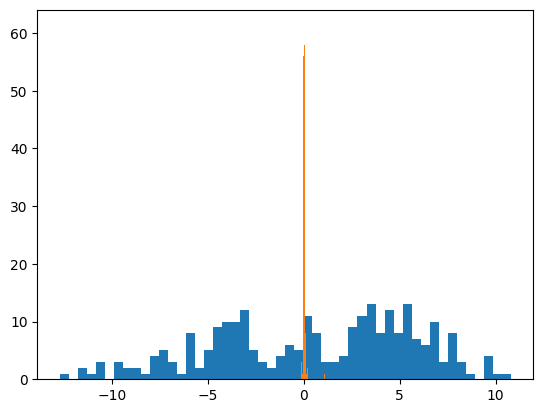

In [11]:
layer = 5

plt.hist(a[layer].numpy(), bins=50)
plt.hist(b[layer].numpy(), bins=50)

#plt.hist(a[layer])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., 11., 11.,
        12.,  8.,  4.,  4.,  4.,  6.,  3.,  9.,  7.,  6.,  6.,  4.,  5.,
         5., 18.,  5.,  8.,  5.,  2.,  5., 13.,  4.,  2.,  3.,  5.,  3.,
         9.,  5.,  5.,  8.,  6.,  8.,  3.,  8., 11., 10.,  2.]),
 array([-20.34450912, -19.66552544, -18.98654175, -18.30755997,
        -17.62857628, -16.94959259, -16.2706089 , -15.59162521,
        -14.91264248, -14.23365879, -13.5546751 , -12.87569237,
        -12.19670868, -11.51772499, -10.83874226, -10.15975857,
         -9.48077488,  -8.80179214,  -8.12280846,  -7.44382524,
         -6.76484203,  -6.08585835,  -5.40687513,  -4.72789192,
         -4.04890823,  -3.36992502,  -2.69094157,  -2.01195836,
         -1.33297491,  -0.65399158,   0.0249918 ,   0.70397514,
          1.38295853,   2.06194186,   2.74092531,   3.41990852,
          4.09889221,   4.77787542,   5.45685863,   6.13584185,
          6.81482553,   7.49380875,   8.17279243,   8.85177517,
          9.

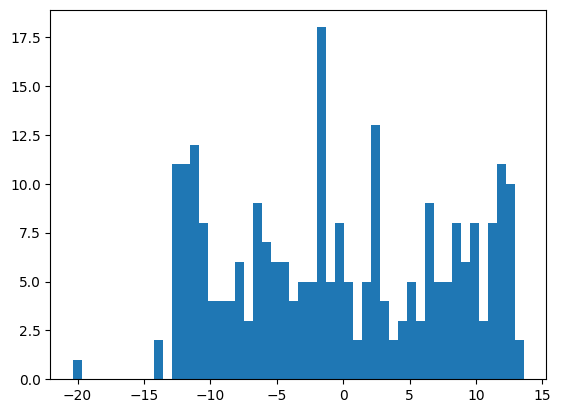

In [12]:
layer = 5

biases[layer].shape
plt.hist(biases[layer].numpy(), bins=50)